In [1]:
import os
from pathlib import Path
current_directory = Path().resolve()
os.chdir(Path(current_directory).resolve().parent.parent)

import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import chardet

plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = False

file_path = current_directory / "conversion_df.csv"

if not file_path.exists():
    raise Exception(f"File {file_path} does not exist.")

with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

df = pd.read_csv(file_path, encoding=file_encoding, sep=',')

df.head()

,temperature,rate_3_diff_reaction_0_conversion,rate_3_diff_reaction_1_conversion,rate_3_diff_reaction_2_conversion,rate_3_diff_reaction_3_conversion,rate_5_diff_reaction_0_conversion,rate_5_diff_reaction_1_conversion,rate_5_diff_reaction_2_conversion,rate_5_diff_reaction_3_conversion,rate_10_diff_reaction_0_conversion,rate_10_diff_reaction_1_conversion,rate_10_diff_reaction_2_conversion,rate_10_diff_reaction_3_conversion
0,30.27800,9.827818e-08,9.972903e-14,1.085497e-95,4.368624e-31,1.631908e-08,1.548049e-12,9.211130e-119,4.843107e-36,2.327450e-08,7.123818e-12,6.808762e-155,2.411354e-26
1,31.23291,2.018687e-07,2.095083e-13,3.233271e-95,9.677860e-31,3.357247e-08,3.220325e-12,2.961691e-118,1.081627e-35,4.776307e-08,1.474954e-11,2.450654e-154,5.173075e-26
2,32.18783,3.111036e-07,3.302654e-13,7.470771e-95,1.613673e-30,5.182243e-08,5.035938e-12,7.472155e-118,1.820201e-35,7.349531e-08,2.290955e-11,7.056580e-154,8.346994e-26
3,33.14274,4.263148e-07,4.630829e-13,1.585870e-94,2.399608e-30,7.113127e-08,6.994890e-12,1.749843e-117,2.734337e-35,1.005601e-07,3.165242e-11,1.899695e-153,1.199494e-25
4,34.09766,5.478344e-07,6.091975e-13,3.248944e-94,3.352762e-30,9.156127e-08,9.129032e-12,3.969752e-117,3.864396e-35,1.290165e-07,4.101052e-11,5.003689e-153,1.615813e-25


<Axes: xlabel='conversion'>

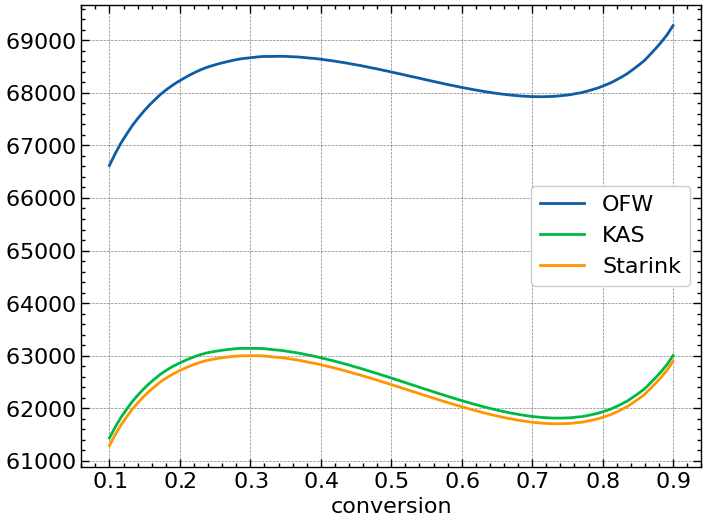

In [2]:
import numpy as np
import scipy.stats as stats
from scipy.constants import R
from scipy.interpolate import interp1d

ALPHA_MIN = 0.1 # Минимальная конверсия
ALPHA_MAX = 0.9 # Максимальная конверсия
reaction_n = "reaction_0"
reaction_cols = [
    f"rate_3_diff_{reaction_n}_conversion",
    f"rate_5_diff_{reaction_n}_conversion",
    f"rate_10_diff_{reaction_n}_conversion",
]
_df = df[[*reaction_cols]].copy()
dadt_data = [_df[col].diff() for col in _df]
reaction_df = pd.DataFrame(dadt_data).T
reaction_df["temperature"] = df["temperature"] + 273.15
reaction_df.columns = ["3", "5", "10", "temperature"]

def fetch_linear_approx_Ea(reaction_df: pd.DataFrame) -> pd.DataFrame:
    rate_cols = [col for col in reaction_df.columns if col != "temperature"]

    conv = reaction_df[rate_cols].cumsum() / reaction_df[rate_cols].cumsum().max()
    temperature = reaction_df["temperature"]

    valid = temperature.notna() & conv.notna().all(axis=1)
    conv, temperature = conv[valid], temperature[valid]

    f = {rate: interp1d(conv[rate], temperature, bounds_error=False, fill_value="extrapolate")
         for rate in rate_cols}

    lower_bound = max(conv.min().min(), ALPHA_MIN)
    upper_bound = min(conv.max().max(), ALPHA_MAX)

    conv_grid = np.linspace(lower_bound, upper_bound, 100)

    T = np.column_stack([f[rate](conv_grid) for rate in rate_cols])
    X = 1.0 / T
    x_mean = X.mean(axis=1, keepdims=True)
    denom = ((X - x_mean) ** 2).sum(axis=1)

    rates = np.array([float(rate) for rate in rate_cols])
    log_rates = np.log(rates)

    # OFW: y = ln(β)
    Y_OFW = np.tile(log_rates, (100, 1))
    slope_OFW = ((X - x_mean) * (Y_OFW - Y_OFW.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    # KAS: y = ln(β) - 2·ln(T)
    Y_KAS = log_rates - 2 * np.log(T)
    slope_KAS = ((X - x_mean) * (Y_KAS - Y_KAS.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    # Starink: y = ln(β) - 1.92·ln(T)
    Y_Starink = log_rates - 1.92 * np.log(T)
    slope_Starink = ((X - x_mean) * (Y_Starink - Y_Starink.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    Ea_OFW = slope_OFW * R / -1.052
    Ea_KAS = slope_KAS * R / -1.0
    Ea_Starink = slope_Starink * R / -1.008

    return pd.DataFrame({
        "conversion": conv_grid,
        "OFW": Ea_OFW,
        "KAS": Ea_KAS,
        "Starink": Ea_Starink
    })

result_df = fetch_linear_approx_Ea(reaction_df)

result_df.plot(x="conversion")


<Axes: xlabel='conversion'>

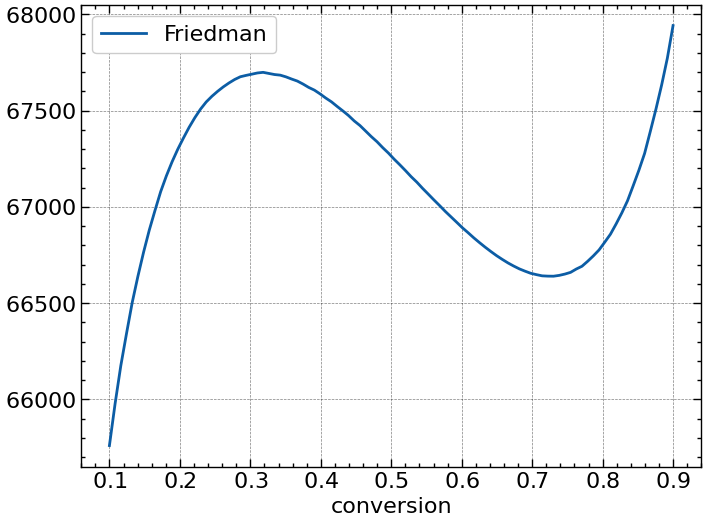

In [3]:
def fetch_friedman_Ea(reaction_df: pd.DataFrame) -> pd.DataFrame:
    rate_cols = [col for col in reaction_df.columns if col != "temperature"]

    conv = reaction_df[rate_cols].cumsum() / reaction_df[rate_cols].cumsum().max()
    temperature = reaction_df["temperature"]

    valid = temperature.notna() & conv.notna().all(axis=1)
    conv, temperature = conv[valid], temperature[valid]

    f = {
        rate: interp1d(conv[rate], temperature, bounds_error=False, fill_value="extrapolate")
        for rate in rate_cols
    }

    lower_bound = max(conv.min().min(), ALPHA_MIN)
    upper_bound = min(conv.max().max(), ALPHA_MAX)
    conv_grid = np.linspace(lower_bound, upper_bound, 100)

    T = np.column_stack([f[rate](conv_grid) for rate in rate_cols])
    X = 1.0 / T

    x_mean = X.mean(axis=1, keepdims=True)
    denom = ((X - x_mean) ** 2).sum(axis=1)

    rates = np.array([float(rate) for rate in rate_cols])
    log_rates = np.log(rates)  # ln(β)

    # ln(dα/dT) = ln(β) - ln(T)
    Y_Friedman = np.tile(log_rates, (len(conv_grid), 1)) - np.log(T)
    slope_Friedman = ((X - x_mean) * (Y_Friedman - Y_Friedman.mean(axis=1, keepdims=True))).sum(axis=1) / denom

    Ea_Friedman = -slope_Friedman * R

    return pd.DataFrame({
        "conversion": conv_grid,
        "Friedman": Ea_Friedman
    })

result_df = fetch_friedman_Ea(reaction_df)

result_df.plot(x="conversion")

In [4]:
def fetch_kissinger_Ea(reaction_df: pd.DataFrame) -> pd.DataFrame:
    rate_cols = [col for col in reaction_df.columns if col != "temperature"]

    temperature_K = reaction_df["temperature"]

    peak_points = []
    for col in rate_cols:
        series = reaction_df[col]

        valid = series.notna() & temperature_K.notna()
        if valid.sum() == 0:
            continue

        cum = series[valid].cumsum()
        conv = cum / cum.iloc[-1]

        idx_peak = series.idxmax()
        T_peak = temperature_K.loc[idx_peak]
        alpha_peak = conv.loc[idx_peak]
        beta_val = float(col)
        peak_points.append((beta_val, T_peak, alpha_peak))

    peak_points.sort(key=lambda x: x[2])

    beta_vals = np.array([pt[0] for pt in peak_points], dtype=float)
    T_peaks = np.array([pt[1] for pt in peak_points], dtype=float)
    alphas = np.array([pt[2] for pt in peak_points], dtype=float)
    
    # X = 1/Tₚ, Y = ln(β / Tₚ²)
    X = 1.0 / T_peaks
    Y = np.log(beta_vals / (T_peaks ** 2))
    slope, intercept = np.polyfit(X, Y, 1)
    E_a = -slope * R

    result_df = pd.DataFrame({
        "conversion": alphas,
        "Kissinger_Ea": [E_a] * len(alphas)
    })
    return result_df

result_df = fetch_kissinger_Ea(reaction_df)

result_df

,conversion,Kissinger_Ea
0,0.654178,57500.04117
1,0.657866,57500.04117
2,0.700434,57500.04117


In [5]:
from scipy.integrate import quad

def calculate(reaction_df: pd.DataFrame) -> pd.DataFrame:
        beta_cols = [col for col in reaction_df.columns if col != "temperature"]

        conv_df = pd.DataFrame()
        for col in beta_cols:
            cum = reaction_df[col].cumsum()
            conv_df[col] = cum / cum.iloc[-1]
        temperature = reaction_df["temperature"]

        f_funcs = {
            col: interp1d(conv_df[col], temperature, bounds_error=False, fill_value="extrapolate")
            for col in beta_cols
        }


        conv_grid = np.linspace(ALPHA_MIN, ALPHA_MAX, 100)

        T_matrix = {}
        for col in beta_cols:
            T_matrix[col] = f_funcs[col](conv_grid)

        beta_vals = {col: float(col) for col in beta_cols}

        dT = reaction_df["temperature"].diff().mean()

        def integrand(T, Ea):
            return np.exp(-Ea / (R * T))

        def I_func(Ea, T, dT):
            integral, _ = quad(integrand, T - dT, T, args=(Ea,))
            return integral

        def vyazovkin_lhs(Ea, dT, pairs):
            n = len(pairs)
            sum_ratio = 0.0
            for i in range(n):
                T_i, beta_i = pairs[i]
                for j in range(n):
                    if i != j:
                        T_j, beta_j = pairs[j]
                        I_i = I_func(Ea, T_i, dT)
                        I_j = I_func(Ea, T_j, dT)
                        sum_ratio += (beta_j / beta_i) * (I_i / I_j)

            result = (n * (n - 1) - sum_ratio) * -1
            return result

        candidate_Ea = np.arange(10000, 300001, 1000)
        estimated_Ea = []

        for idx, alpha in enumerate(conv_grid):
            pairs = []
            for col in beta_cols:
                pairs.append((T_matrix[col][idx], beta_vals[col]))

            f_vals = [abs(vyazovkin_lhs(Ea, dT, pairs)) for Ea in candidate_Ea]
            best_index = np.argmin(f_vals)
            best_Ea = candidate_Ea[best_index]
            estimated_Ea.append(best_Ea)

        result_df = pd.DataFrame({"conversion": conv_grid, "Vyazovkin": estimated_Ea})
        return result_df

# result_df = calculate(reaction_df)

# result_df.plot(x="conversion")

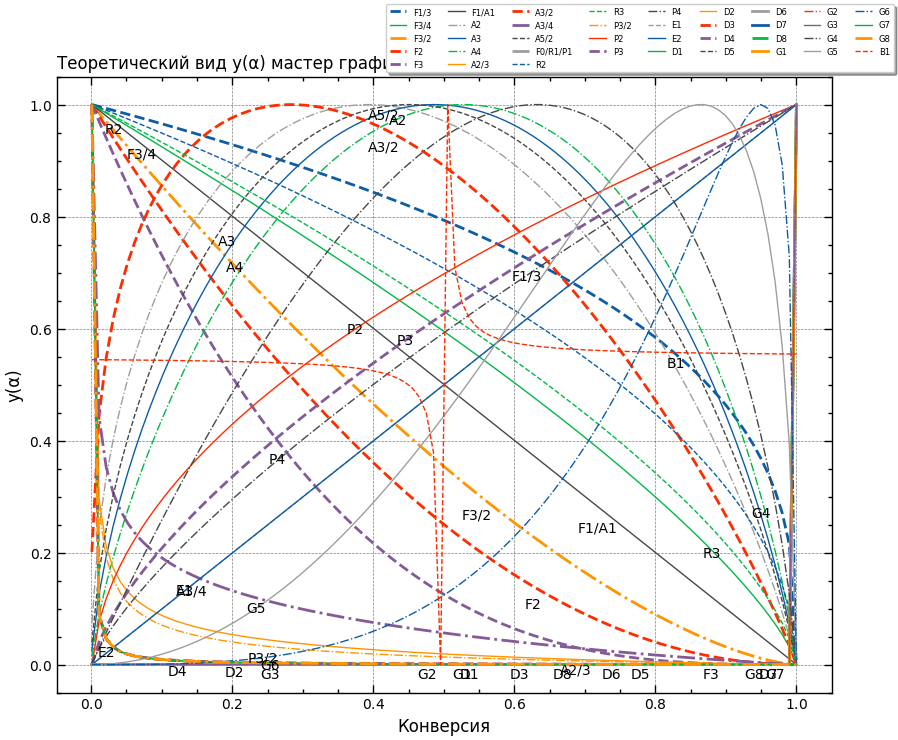

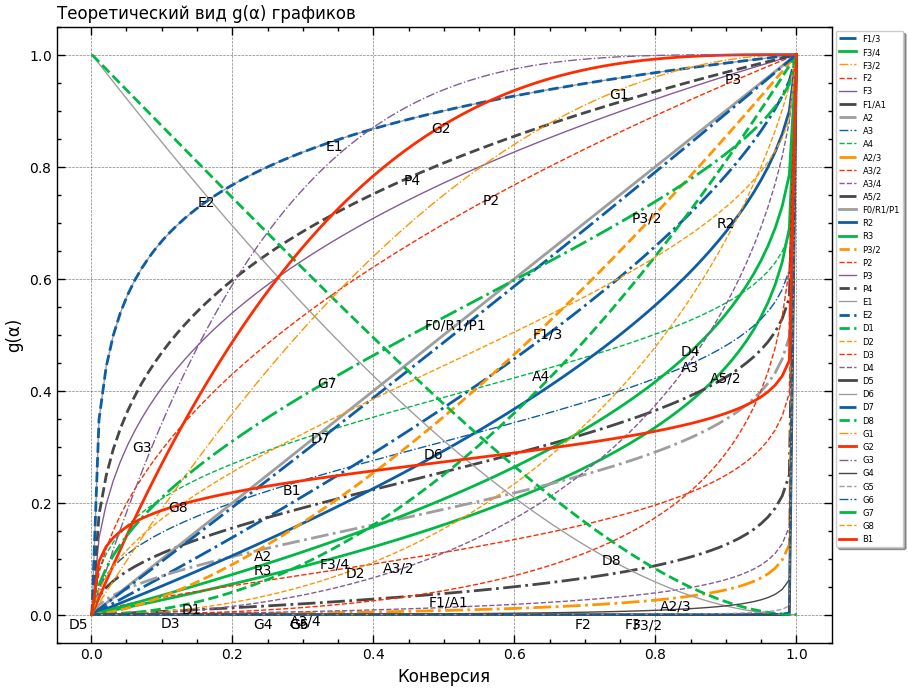

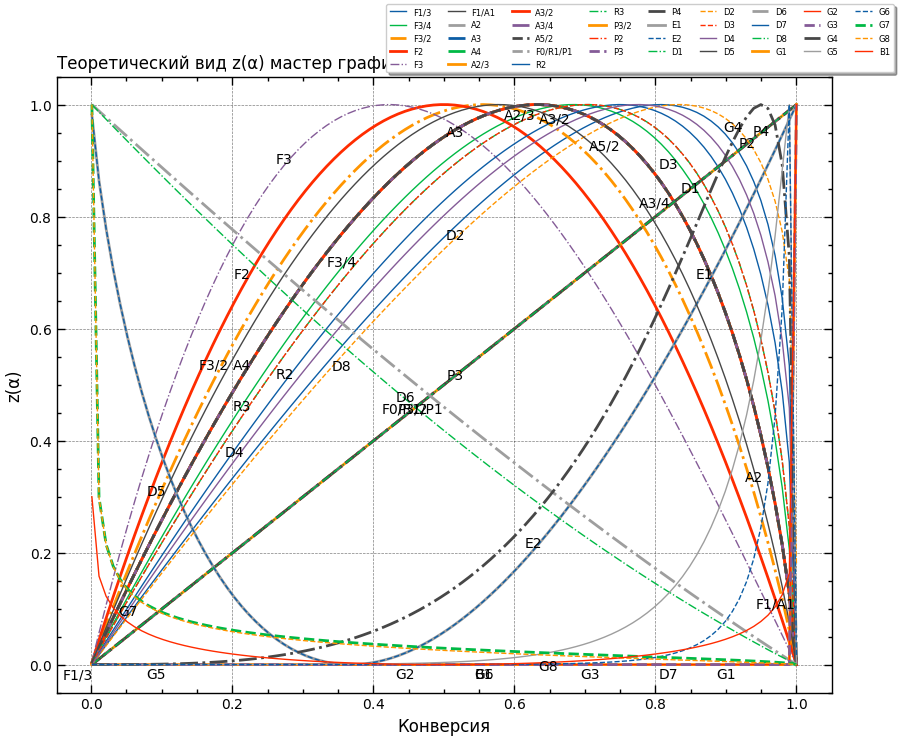

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Для генерации случайных стилей линий
def get_random_line_style_and_width():
    line_styles = ['-', '--', '-.']
    line_widths = [1, 2]
    return np.random.choice(line_styles), np.random.choice(line_widths)

def normalize_data(data):
    if np.isinf(np.max(data)) or np.isnan(np.max(data)):
        data_max = np.nanmax(data[~np.isinf(data) & ~np.isnan(data)])
    else:
        data_max = np.max(data)
                
    if np.isinf(np.min(data)) or np.isnan(np.min(data)):
        data_min = np.nanmin(data[~np.isinf(data) & ~np.isnan(data)])
    else:
        data_min = np.min(data) 
    return (data - data_min) / (data_max - data_min)

# Размеры шрифтов для подписей (можно настроить)
MEDIUM_SIZE = 12
SMALL_SIZE = 10

# Импортируем словарь с моделями
from src.core.app_settings import NUC_MODELS_TABLE

def plot_y(a, models_table):
    fig, ax = plt.subplots(figsize=(10, 8))
    e = 1 - a
    
    for model, funcs in models_table.items():
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                y = funcs['differential_form'](e)
                y_norm = normalize_data(y)
                
                line_style, line_width = get_random_line_style_and_width()
                ax.plot(a, y_norm, label=model, linestyle=line_style, linewidth=line_width)
                                
                # Добавляем метку модели в случайной точке графика
                rand_index = np.random.choice(range(len(a)))
                ax.annotate(model, (a[rand_index], y_norm[rand_index]),
                            textcoords="offset points", xytext=(-10, -10), ha='center')
        except Exception as exc:
            print(f"Проблема с моделью {model}: {str(exc)}")
    
    ax.legend(loc='best', bbox_to_anchor=(0.42, 1.00), ncol=9, fancybox=True, shadow=True, prop={'size': 6})
    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
    ax.set_title('Теоретический вид y(α) мастер графиков', fontsize=MEDIUM_SIZE, loc='left')
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    plt.show()

def plot_g(a, models_table):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    e = 1 - a
    for model, funcs in models_table.items():
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                g = funcs['integral_form'](e)
                g_norm = normalize_data(g)
                
                line_style, line_width = get_random_line_style_and_width()
                ax.plot(a, g_norm, label=model, linestyle=line_style, linewidth=line_width)
                
                rand_index = np.random.choice(range(len(a)))
                ax.annotate(model, (a[rand_index], g_norm[rand_index]),
                            textcoords="offset points", xytext=(-10, -10), ha='center')
        except Exception as exc:
            print(f"Проблема с моделью {model}: {str(exc)}")
            
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, prop={'size': 6})
    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('g(α)', fontsize=MEDIUM_SIZE)
    ax.set_title('Теоретический вид g(α) графиков', fontsize=MEDIUM_SIZE, loc='left')
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    plt.show()

def plot_z(a, models_table):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    e = 1 - a
    for model, funcs in models_table.items():
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                y = funcs['differential_form'](e)
                g = funcs['integral_form'](e)
                z = y * g
                z_norm = normalize_data(z)
                
                line_style, line_width = get_random_line_style_and_width()
                ax.plot(a, z_norm, label=model, linestyle=line_style, linewidth=line_width)
                
                rand_index = np.random.choice(range(len(a)))
                ax.annotate(model, (a[rand_index], z_norm[rand_index]),
                            textcoords="offset points", xytext=(-10, -10), ha='center')
        except Exception as exc:
            print(f"Проблема с моделью {model}: {str(exc)}")
    
    ax.legend(loc='best', bbox_to_anchor=(0.42, 1.00), ncol=9, fancybox=True, shadow=True, prop={'size': 6})
    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('z(α)', fontsize=MEDIUM_SIZE)
    ax.set_title('Теоретический вид z(α) мастер графиков', fontsize=MEDIUM_SIZE, loc='left')
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    plt.show()

# Создаем значения a от 0 до 1
a = np.linspace(0.001, 1, 100)

# Отрисовка графиков
plot_y(a, NUC_MODELS_TABLE)
plot_g(a, NUC_MODELS_TABLE)
plot_z(a, NUC_MODELS_TABLE)


<Axes: xlabel='conversion'>

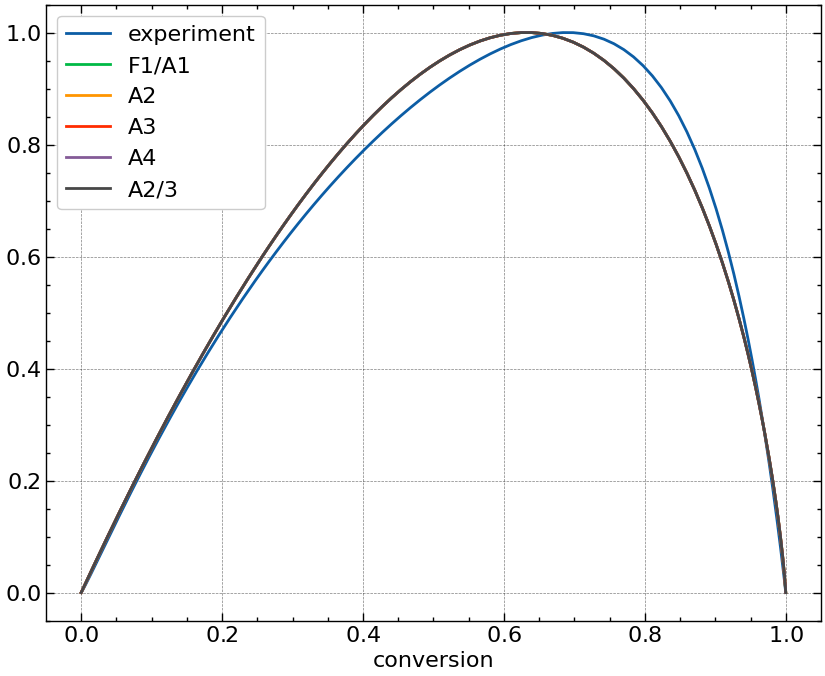

In [7]:
from scipy import integrate
E_MEAN = 67_000

def r2_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def get_exp_term(Ea_mean, temperature):
    return np.exp(Ea_mean / (R * temperature))

def calculate_y_master_plot(da_dt, exp_term):
    y_a = da_dt * exp_term
    y_a_norm = (y_a - y_a.min()) / (y_a.max() - y_a.min())
    return y_a_norm

def calculate_g_master_plot(temperature_a: np.ndarray):
    def integrand(T):
        return np.exp(-E_MEAN / (R * T))
    
    N = len(temperature_a)
    g_values = []
    for i in range(N):
        if i == 0:
            # Для первой точки используем интервал от T[0] до среднего между T[0] и T[1]
            lower_bound = temperature_a[i]
            upper_bound = (temperature_a[i] + temperature_a[i+1]) / 2
        elif i == N - 1:
            # Для последней точки используем интервал от среднего между T[N-2] и T[N-1] до T[N-1]
            lower_bound = (temperature_a[i-1] + temperature_a[i]) / 2
            upper_bound = temperature_a[i]
        else:
            # Для промежуточных точек используем интервал от среднего с предыдущим значением до среднего с последующим
            lower_bound = (temperature_a[i-1] + temperature_a[i]) / 2
            upper_bound = (temperature_a[i] + temperature_a[i+1]) / 2
        
        integral_value, _ = integrate.quad(integrand, lower_bound, upper_bound)
        g_values.append(integral_value)
    
    g_a = np.array(g_values)
    g_norm = (g_a - g_a.min()) / (g_a.max() - g_a.min())
    return g_norm

def calculate_z_master_plot(da_dt, temperature_a: np.ndarray):
    z = da_dt * temperature_a**2
    z_norm = (z - z.min()) / (z.max() - z.min())
    return z_norm


def normalize_data(data):
    data = np.array(data)
    finite_data = data[~np.isinf(data)]
    data_max = np.nanmax(finite_data)
    data_min = np.nanmin(finite_data)
    if data_max == data_min:
        return np.zeros_like(data)
    return (data - data_min) / (data_max - data_min)

def model_r2_scores(experiment_norm, conversion, model_form, z_a=False):
    e = 1 - conversion
    r2_scores = {}
    model_predictions = {}
    for model, funcs in NUC_MODELS_TABLE.items():
        try:
            with warnings.catch_warnings():
                raw_model = (
                    funcs[model_form](e) if not z_a else funcs["differential_form"](e) * funcs["integral_form"](e)
                )
                model_norm = normalize_data(raw_model)
                score = r2_score(experiment_norm, model_norm)
                r2_scores[model] = score
                model_predictions[model] = model_norm
        except Exception as exception:
            print(f"Проблема с моделью {model}: {exception}")

    top_models = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    df_dict = {'conversion': conversion, 'experiment': experiment_norm}
    for model, score in top_models:
        df_dict[model] = model_predictions[model]
    return pd.DataFrame(df_dict)

rate_cols = [col for col in reaction_df.columns if col != "temperature"]
temperature = reaction_df["temperature"].values

y_a_results = {}
g_a_results = {}
z_a_results = {}
for beta in rate_cols:
    da_dT = reaction_df[beta].values

    valid = ~np.isnan(temperature) & ~np.isnan(da_dT)
    da_dT, temperature_valid = da_dT[valid], temperature[valid]
    conversion = da_dT.cumsum() / da_dT.cumsum().max()

    exp_term = get_exp_term(E_MEAN, temperature_valid)
    y_a_norm = calculate_y_master_plot(da_dT, exp_term)
    g_a_norm = calculate_g_master_plot(temperature_valid)
    z_a_norm = calculate_z_master_plot(da_dT, temperature_valid)
    sorted_ya_r2 = model_r2_scores(y_a_norm, conversion, "differential_form")
    sorted_ga_r2 = model_r2_scores(g_a_norm, conversion, "integral_form")
    sorted_za_r2 = model_r2_scores(z_a_norm, conversion, "_", z_a=True)
    y_a_results[beta] = sorted_ya_r2
    g_a_results[beta] = sorted_ga_r2
    z_a_results[beta] = sorted_za_r2


z_a_results["3"].plot(x='conversion', figsize=(10, 8))


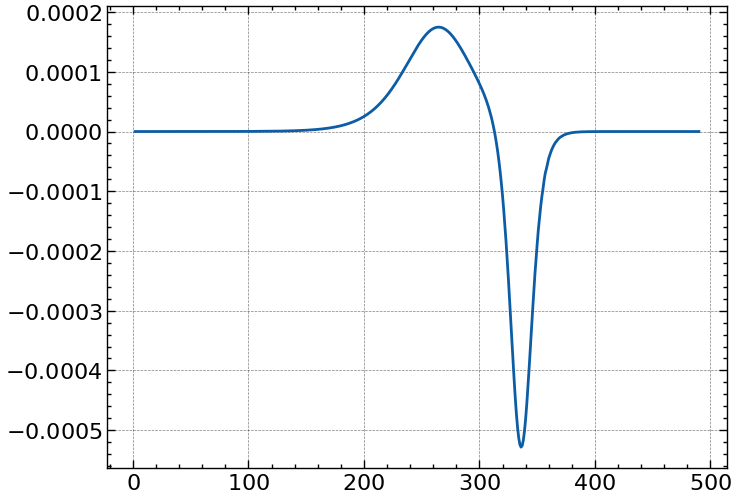

In [ ]:
np.gradient(reaction_df[beta].values)